Source
https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import datetime
import IPython
import IPython.display

# Data preperation

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

### Create data frame from input file

In [3]:
df = pd.read_csv('building_data.csv').interpolate().fillna(0)
df['Time'] = pd.to_datetime(df['Time'], infer_datetime_format=True)

In [4]:
df

,Time,Day,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Office_Elizabeth,Office_Ellie,Office_Evelyn,Office_Eileen,Office_Bobbi,Office_Benjamin,Office_Bianca,Office_Benthe,Office_Brian,Office_Bryon
0,2012-01-01 05:00:00+00:00,Sunday,0.08283,0.000,11.1,3.163383,6.970150,240.968342,0.000000,0.000,0.00,0.00000,0.00,0.00000,0.000
1,2012-01-01 06:00:00+00:00,Sunday,0.08283,0.000,10.0,3.170692,6.780483,142.524367,0.000000,0.000,0.00,0.00000,0.00,0.00000,0.000
2,2012-01-01 07:00:00+00:00,Sunday,0.08283,0.000,10.0,3.186217,6.970150,160.405408,0.000000,0.000,0.00,0.00000,0.00,0.00000,0.000
3,2012-01-01 08:00:00+00:00,Sunday,0.08283,743.711,10.0,3.159733,6.685650,155.820508,0.000000,41.775,44.75,19.56675,142.25,73.82075,273.150
4,2012-01-01 09:00:00+00:00,Sunday,0.08283,1479.480,10.0,3.167025,6.922733,150.711650,0.000000,42.525,42.25,17.51600,143.00,74.88975,267.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,Monday,0.09690,0.000,14.4,11.650250,31.958475,272.997017,64.280192,46.025,54.00,19.69750,135.50,79.16700,238.175
8775,2012-12-31 20:00:00+00:00,Monday,0.09690,0.000,15.0,11.485775,32.432617,278.498908,64.156942,44.050,54.00,18.84550,137.00,79.64075,244.500
8776,2012-12-31 21:00:00+00:00,Monday,0.08283,0.000,15.0,11.485775,32.432617,278.498908,64.156942,46.450,53.25,19.05500,138.25,79.99925,246.450
8777,2012-12-31 22:00:00+00:00,Monday,0.08283,0.000,15.0,11.485775,32.432617,278.498908,64.156942,44.075,54.00,20.61675,141.50,85.80275,238.500


### Create aggregated data frame

In [5]:
df["Power consumption (kWh)"] = df.iloc[:,5:].sum(axis=1)
aggregated = df.drop(df.columns[5:-1], axis=1)

In [6]:
# Swap order so that
aggregated = aggregated.reindex(['Time', 'Day', 'Price( $ per kWh)', 'PV (W)', 'Temperature in LA in 2012 (Celsius)', 'Power consumption (kWh)'], axis=1)

In [7]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

aggregated = filter_rows_by_values(aggregated, "Power consumption (kWh)", [0])


In [8]:
aggregated

,Time,Day,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,Sunday,0.08283,0.000,11.1,251.101875
1,2012-01-01 06:00:00+00:00,Sunday,0.08283,0.000,10.0,152.475542
2,2012-01-01 07:00:00+00:00,Sunday,0.08283,0.000,10.0,170.561775
3,2012-01-01 08:00:00+00:00,Sunday,0.08283,743.711,10.0,760.978392
4,2012-01-01 09:00:00+00:00,Sunday,0.08283,1479.480,10.0,748.907158
...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,Monday,0.09690,0.000,14.4,953.450433
8775,2012-12-31 20:00:00+00:00,Monday,0.09690,0.000,15.0,964.610492
8776,2012-12-31 21:00:00+00:00,Monday,0.08283,0.000,15.0,970.028492
8777,2012-12-31 22:00:00+00:00,Monday,0.08283,0.000,15.0,971.068742


### Add time variables

In [9]:
aggregated.insert(2, 'Day of Week', aggregated['Day'], True)
aggregated.insert(1, 'Year', aggregated['Time'].map(lambda x: x.year), True)
aggregated.insert(2, 'Day of Year', aggregated['Time'].map(lambda x: x.dayofyear), True)
aggregated.drop('Day', axis=1, inplace=True)
aggregated.insert(3, 'Hour', aggregated['Time'].map(lambda x: x.hour), True)

In [10]:
aggregated

,Time,Year,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,2012,1,5,Sunday,0.08283,0.000,11.1,251.101875
1,2012-01-01 06:00:00+00:00,2012,1,6,Sunday,0.08283,0.000,10.0,152.475542
2,2012-01-01 07:00:00+00:00,2012,1,7,Sunday,0.08283,0.000,10.0,170.561775
3,2012-01-01 08:00:00+00:00,2012,1,8,Sunday,0.08283,743.711,10.0,760.978392
4,2012-01-01 09:00:00+00:00,2012,1,9,Sunday,0.08283,1479.480,10.0,748.907158
...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,2012,366,19,Monday,0.09690,0.000,14.4,953.450433
8775,2012-12-31 20:00:00+00:00,2012,366,20,Monday,0.09690,0.000,15.0,964.610492
8776,2012-12-31 21:00:00+00:00,2012,366,21,Monday,0.08283,0.000,15.0,970.028492
8777,2012-12-31 22:00:00+00:00,2012,366,22,Monday,0.08283,0.000,15.0,971.068742


### Encode and Scale data

In [11]:
# encode categorical data
encoder = LabelEncoder()
encoding_columns = ["Day of Week"]
for column in encoding_columns:
    aggregated[column] = encoder.fit_transform(aggregated[column]).astype('float32')

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
# these columns are NOT scaled
scalable_columns = aggregated.columns.difference(["Time"])
aggregated[scalable_columns] = scaler.fit_transform(aggregated[scalable_columns])

### Resulting prepared data

In [13]:
prepared_data = aggregated.reset_index(inplace=False, drop=True)
prepared_data

,Time,Year,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,2012-01-01 05:00:00+00:00,0.0,0.0,0.217391,0.500000,0.028415,0.000000,0.549433,0.069522
1,2012-01-01 06:00:00+00:00,0.0,0.0,0.260870,0.500000,0.028415,0.000000,0.531605,0.000000
2,2012-01-01 07:00:00+00:00,0.0,0.0,0.304348,0.500000,0.028415,0.000000,0.531605,0.012749
3,2012-01-01 08:00:00+00:00,0.0,0.0,0.347826,0.500000,0.028415,0.223776,0.531605,0.428937
4,2012-01-01 09:00:00+00:00,0.0,0.0,0.391304,0.500000,0.028415,0.445162,0.531605,0.420428
...,...,...,...,...,...,...,...,...,...
8774,2012-12-31 19:00:00+00:00,0.0,1.0,0.826087,0.166667,0.090592,0.000000,0.602917,0.564612
8775,2012-12-31 20:00:00+00:00,0.0,1.0,0.869565,0.166667,0.090592,0.000000,0.612642,0.572478
8776,2012-12-31 21:00:00+00:00,0.0,1.0,0.913043,0.166667,0.028415,0.000000,0.612642,0.576298
8777,2012-12-31 22:00:00+00:00,0.0,1.0,0.956522,0.166667,0.028415,0.000000,0.612642,0.577031


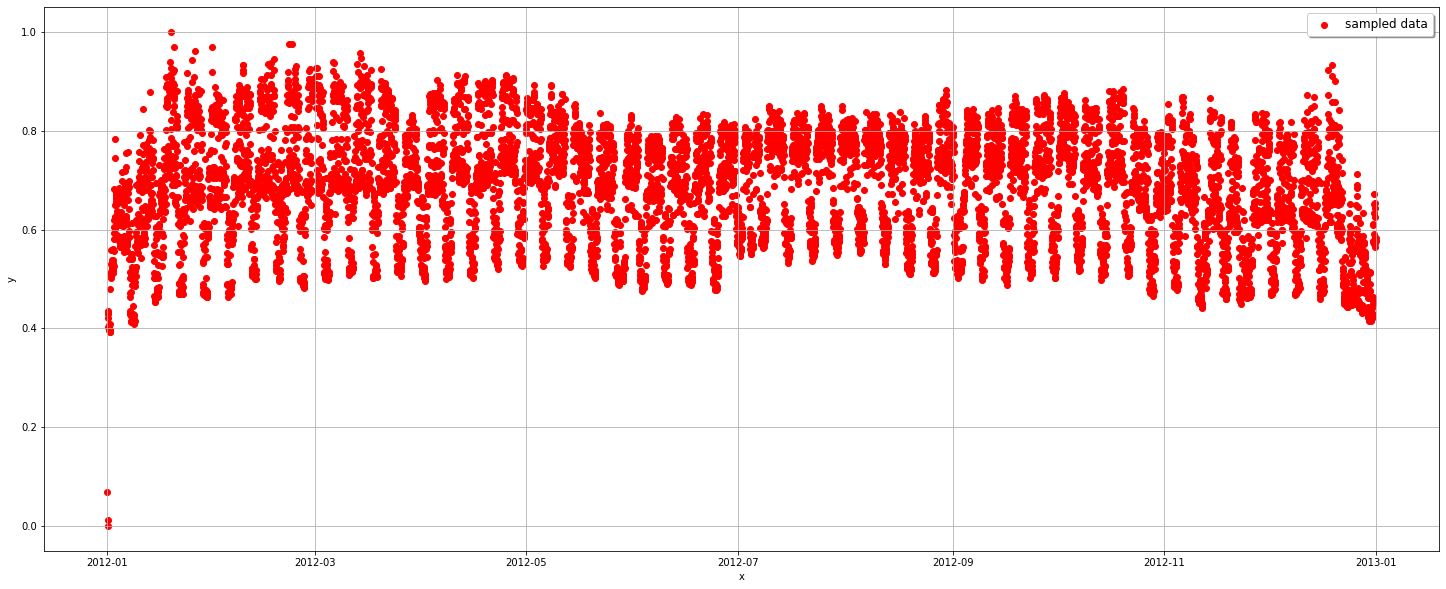

In [14]:
# Graph of prepared data (graph repeated later)
fig, ax = plt.subplots(figsize=(25,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

ax.scatter(prepared_data.loc[:,'Time'],prepared_data.loc[:,'Power consumption (kWh)'],c="r",label='sampled data')
ax.legend(fontsize='large',shadow=True, bbox_to_anchor=(1, 1))
plt.show()

# Model Tools

## Imports

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
import math
from sklearn.utils import shuffle
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Layer, Input

## Constants

In [16]:
MEASURE_COLUMN_NAME = "Day of Year"
TRAINING_DATA_DECIMAL = 0.7
VALIDATION_DATA_DECIMAL = 0.2
TEST_DATA_DECIMAL = 0.1

In [17]:
# The number of timesteps to be used as input
INPUT_STEP_COUNT = 24 # input_width
# The number of timesteps to be used as output
OUTPUT_STEP_COUNT = 1 # label_width
# The column(s) to be predicted
OUTPUT_COLUMN_NAMES = ["Power consumption (kWh)"] # label_columns
PRIMARY_OUTPUT_COLUMN = OUTPUT_COLUMN_NAMES[0]

In [18]:
# The column(s) to ignore
IGNORE_COLUMN_NAMES = ["Year", "Time"]

## Window Generator

#### Helper Functions

In [19]:
if not np.isclose(TRAINING_DATA_DECIMAL + VALIDATION_DATA_DECIMAL + TEST_DATA_DECIMAL, 1, rtol=1e-05, atol=1e-08, equal_nan=False):
    raise ValueError('Invalid data decimals')

def errorIfDecimalInvalid(decimal):
    if decimal < 0 or decimal > 1:
        raise ValueError('Reached invalid decimal')
        
def isTraining(decimal):
    errorIfDecimalInvalid(decimal)
    return (decimal < 0.7)

def isValidation(decimal):
    errorIfDecimalInvalid(decimal)
    return (not isTraining(decimal) and decimal < TRAINING_DATA_DECIMAL + VALIDATION_DATA_DECIMAL)

def isTest(decimal):
    errorIfDecimalInvalid(decimal)
    return (not isTraining(decimal) and not isValidation(decimal))

### Format data

In [20]:
time_series_data = prepared_data.copy()

In [21]:
time_series_data.drop(IGNORE_COLUMN_NAMES, axis=1, inplace=True)

#### Handle Time column (not in use)

In [22]:
# date_time = pd.to_datetime(time_series_data.pop('Time'), format='%d.%m.%Y %H:%M:%S')
# timestamp_s = date_time.map(pd.Timestamp.timestamp)

# day = 24*60*60
# year = (365.2425)*day

# time_series_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# time_series_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
# time_series_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# time_series_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#### Declare variables

In [23]:
column_indices = {name: i for i, name in enumerate(time_series_data.columns)}

In [24]:
training_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isTraining)]
validation_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isValidation)]
test_dataframe = time_series_data.loc[time_series_data[MEASURE_COLUMN_NAME].apply(isTest)]

In [25]:
training_dataframe

,Day of Year,Hour,Day of Week,Price( $ per kWh),PV (W),Temperature in LA in 2012 (Celsius),Power consumption (kWh)
0,0.00000,0.217391,0.5,0.028415,0.000000,0.549433,0.069522
1,0.00000,0.260870,0.5,0.028415,0.000000,0.531605,0.000000
2,0.00000,0.304348,0.5,0.028415,0.000000,0.531605,0.012749
3,0.00000,0.347826,0.5,0.028415,0.223776,0.531605,0.428937
4,0.00000,0.391304,0.5,0.028415,0.445162,0.531605,0.420428
...,...,...,...,...,...,...,...
6134,0.69863,0.826087,1.0,0.262628,0.000000,0.784441,0.755793
6135,0.69863,0.869565,1.0,0.262628,0.000000,0.784441,0.751523
6136,0.69863,0.913043,1.0,0.000000,0.000000,0.756888,0.804689
6137,0.69863,0.956522,1.0,0.000000,0.000000,0.739060,0.766296


### Window Class

#### Class definition

In [26]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=training_dataframe, val_df=validation_dataframe, test_df=test_dataframe,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

#### Split window function

In [27]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

#### Plot function

In [28]:
def plot(self, model=None, plot_col=PRIMARY_OUTPUT_COLUMN, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col[0:10]}. [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#### Make dataset function

In [29]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # TODO: Review the options for timeseries_dataset_from_array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

#### Accessor methods

In [30]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Training Functions

In [31]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history


# Single Step Models

## Windows

### Single Step window

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=OUTPUT_COLUMN_NAMES)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Power consumption (kWh)']

In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

2021-10-22 01:44:05.608516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


2021-10-22 01:44:05.904514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Wide Window

In [34]:
# Wide window does not change prediction, but rather acts like showing a number of batches.
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[PRIMARY_OUTPUT_COLUMN])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Power consumption (kWh)']

### Conv Window
Takes multiple time steps as input

In [35]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[PRIMARY_OUTPUT_COLUMN])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Power consumption (kWh)']

Text(0.5, 3.4, 'Given 3 hours of inputs, predict 1 hour into the future.')

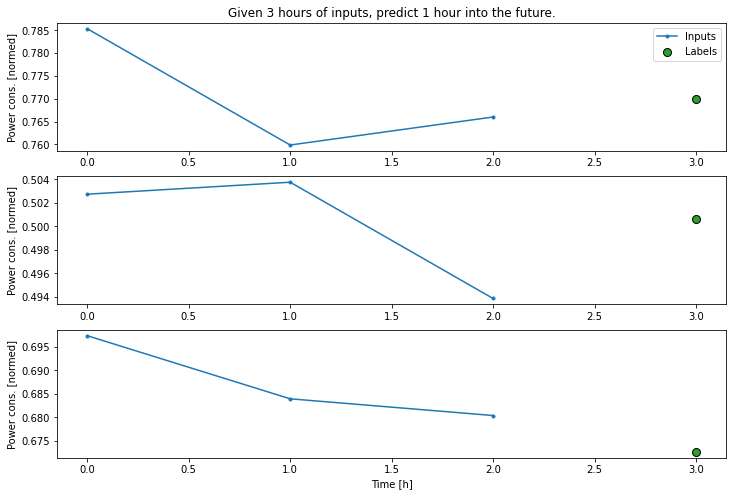

In [36]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.", y=3.4)

## Generate Performance Baseline

### Define Model

In [37]:
# the baseline is simply predicting the next value to be the most recent value
# in other words the prediction equals the input
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

### Instantiate and evaluate model

In [38]:
baseline = Baseline(label_index=column_indices[PRIMARY_OUTPUT_COLUMN])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 964us/step - loss: 8.0624e-04 - mean_absolute_error: 0.0200


### Graph results

In [39]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


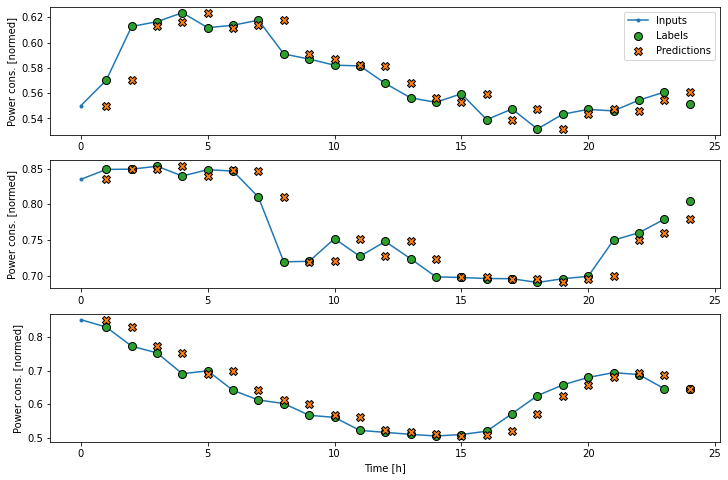

In [40]:
# the baseline is simply predicting the next value to be the past value as can be seen in the graph
wide_window.plot(baseline)

## Generate Linear Model

### Define Model

In [41]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [42]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


### Instantiate and evaluate model

In [43]:
history = compile_and_fit(linear, single_step_window)

IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_absolute_error: 0.0492


### Graph result

In [44]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


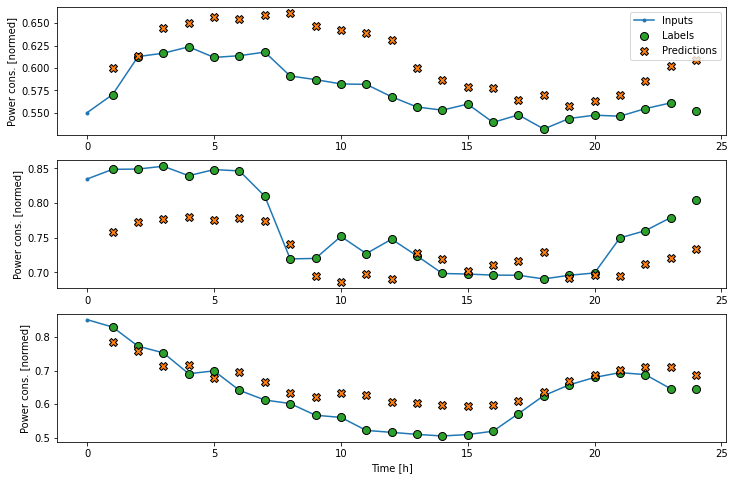

In [45]:
wide_window.plot(linear)

### Interpret Model
Displays the weights associated with the trained linear model

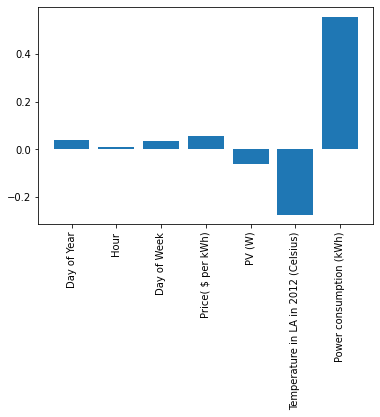

In [46]:
plt.bar(x = range(len(training_dataframe.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(training_dataframe.columns)))
_ = axis.set_xticklabels(training_dataframe.columns, rotation=90)

## Generate Dense Model

### Define Model

In [47]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [48]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', dense(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


### Instantiate and evaluate model

In [49]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

55/55 [==============================] - 0s 1ms/step - loss: 0.0010 - mean_absolute_error: 0.0261


### Graph result

In [50]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', dense(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


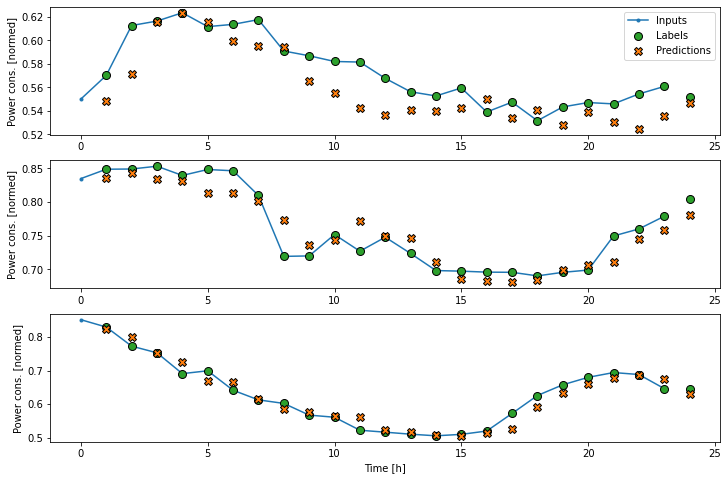

In [51]:
wide_window.plot(dense)

## Generate Multi-step Dense Model
Issue with this model is that it can only be executed on input windows of exactly its shape

### Define Model

In [52]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [53]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


### Instantiate and evaluate model

In [54]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

55/55 [==============================] - 0s 1ms/step - loss: 0.0016 - mean_absolute_error: 0.0310


### Graph result

Text(0.5, 3.4, 'Given 3 hours of inputs, predict 1 hour into the future.')

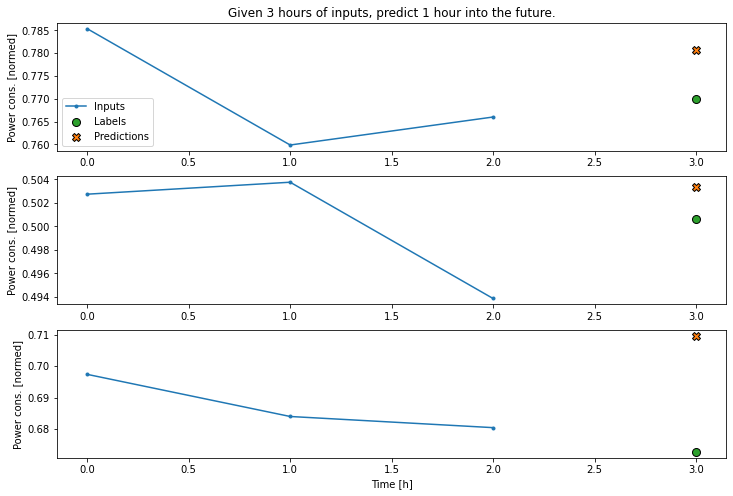

In [55]:
conv_window.plot(multi_step_dense)
plt.title("Given 3 hours of inputs, predict 1 hour into the future.", y=3.4)

## Generate Convolutional Neural Network Model
Difference with multi_step_step dense is that can be run on inputs of any length.
"The convolutional layer is applied to a sliding window of inputs"

### Define Model

In [56]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [57]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


### Instantiate and evaluate model

In [58]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0263


#### Can run on wider input to produce wider ouput
Unlike multi-step dense

In [59]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


### Graph result

"Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match"

In [60]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[PRIMARY_OUTPUT_COLUMN])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Power consumption (kWh)']

In [61]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Text(0.5, 3.4, 'Given 24 hours of inputs, predict 1 hour into the future.')

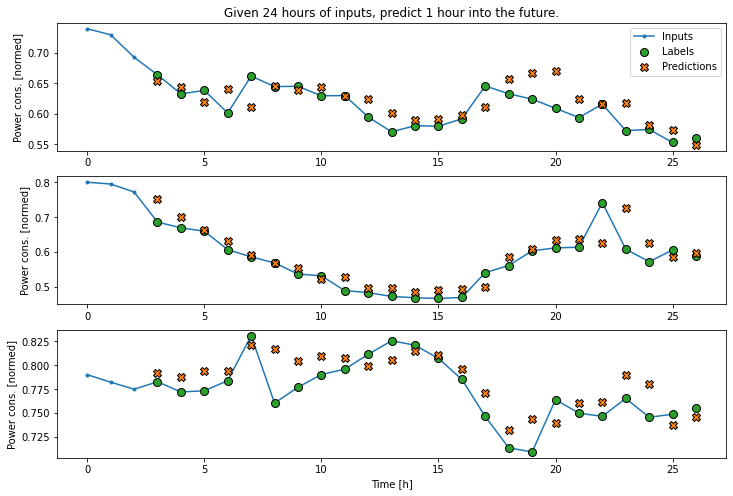

In [62]:
wide_conv_window.plot(conv_model)
plt.title(f"Given {LABEL_WIDTH} hours of inputs, predict 1 hour into the future.", y=3.4)

## Generate Recurrent Neural Network Model

### Define Model

In [63]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [64]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


### Instantiate and evaluate model

In [65]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

54/54 [==============================] - 0s 3ms/step - loss: 8.0833e-04 - mean_absolute_error: 0.0224


### Graph result

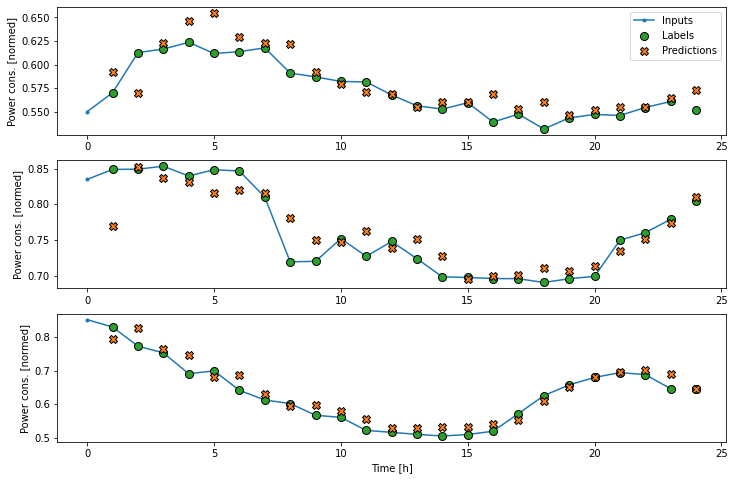

In [66]:
wide_window.plot(lstm_model)

## Generate Residual Connections LSTM Model

### Create wrapper model class

In [67]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs[:,:,6:7] + delta

### Define model

In [68]:

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        units= 1,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

### Instantiate and evaluate model

In [69]:
history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

54/54 [==============================] - 0s 3ms/step - loss: 6.8386e-04 - mean_absolute_error: 0.0200


### Graph result

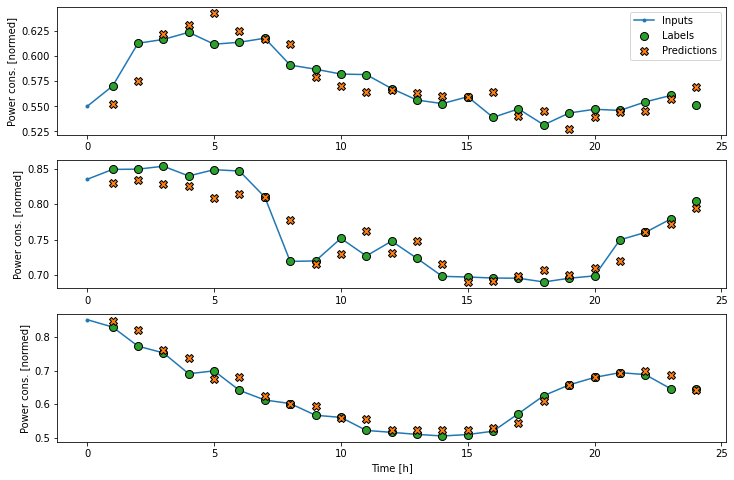

In [70]:
wide_window.plot(residual_lstm)

## Compare Models

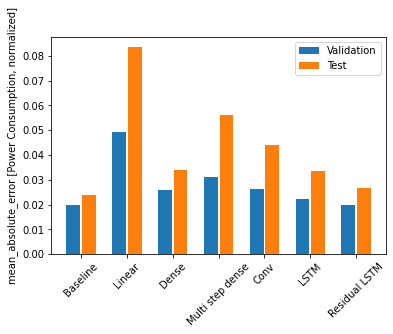

In [71]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Power Consumption, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [72]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0238
Linear      : 0.0835
Dense       : 0.0340
Multi step dense: 0.0561
Conv        : 0.0440
LSTM        : 0.0337
Residual LSTM: 0.0266


# Multi-ouput models

## Generate Residual Connections LSTM Model

In [73]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

54/54 [==============================] - 0s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0341


### Create wrapper model class

In [74]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

### Define model

In [75]:
num_features_test = 7

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        units= num_features_test,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

### Instantiate and evaluate model

In [76]:
history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

54/54 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0266



### Graph result

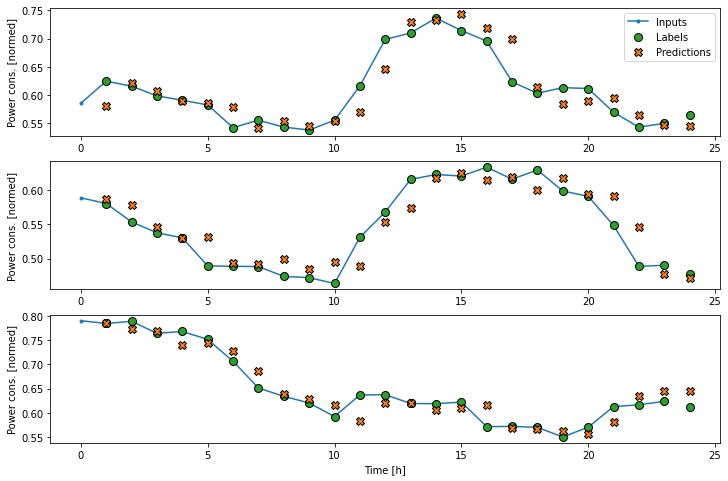

In [77]:
wide_window.plot(residual_lstm)

## Compare Models

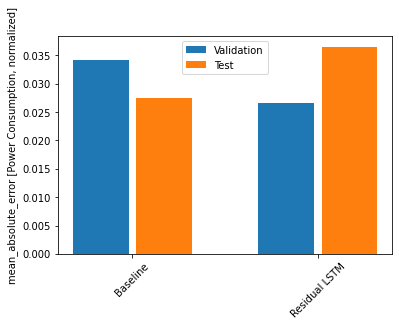

In [78]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Power Consumption, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [79]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0275
Residual LSTM: 0.0365
